In [1]:
import numpy as np
import matplotlib.pyplot as plt
from run import agents, run_agent, AgentStats, compute_statistics
from numpy.typing import NDArray
from typing import NamedTuple, Sequence, Tuple
from deepsea import MultiRewardsDeepSea
import multiprocessing as mp
from scipy.stats import t as tstudent
import pickle
import lzma
import seaborn as sns
from deepsea import MultiRewardsDeepSea
import pandas as pd
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class Results(NamedTuple):
    training_rewards: NDArray[np.float64]
    greedy_rewards: Sequence[Tuple[int, NDArray[np.float64]]]
    regret: NDArray[np.float64]
    agent_stats: AgentStats
    
    
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)


/home/alessior/anaconda3/envs/exploration-maze/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [124]:
import matplotlib as mpl
TITLE_SIZE = 18
LEGEND_SIZE = 14
TICK_SIZE = 15
AXIS_TITLE = TITLE_SIZE-4
AXIS_LABEL = 14
FONT_SIZE = TITLE_SIZE-4


plt.rc('font', size=FONT_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=AXIS_TITLE)     # fontsize of the axes title
plt.rc('axes', labelsize=AXIS_LABEL)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=TICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,  # use inline math for ticks
    "pgf.rcfonts": False,  # don't setup fonts from rc parameters
    "pgf.preamble": []
})

sns.set()



In [119]:
SIZES = [10, 20, 30, 40]#, 50]
# EPISODES = {10: 500, 15: 1000, 20: 1500, 30: 2500, 40:3500, 50: 4500}
EPISODES = {10: 1000, 20: 2000, 30: 3000, 40: 4000, 50: 50000}
AGENTS = ['boot_dqn_torch_modified', 'explorative_generative_off_policy','boot_dqn_torch', 'ids']


raw_data = {x: {agent: None for agent in AGENTS} for x in SIZES}
data = {}
df = pd.DataFrame({
    'method': [],
    'size': [],
    'spread': []
})


for size in SIZES:
    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)
    for agent in AGENTS:
        with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:               
            raw_data[size] = pickle.load(f)
            res = np.array(raw_data[size].training_rewards)
            if agent not in data: data[agent] = {}


            x: Results = raw_data[size]
            y = []
            mask = np.zeros_like(x.agent_stats[0].total_num_visits, dtype=bool)
            mask[np.tril_indices_from(mask)] = True

            # n^2-n is the minimum spread possible, while n^2-2 is the maximum possible spread (as long as the agent has visited all states at least once)
            y = np.array([
                np.std(x.agent_stats[i].last_visit[mask]/ ( size*EPISODES[size]) )
                for i in range(len(x.agent_stats))])# / (size * EPISODES[size])
   
            for i in range(len(y)):
                df.loc[len(df)] = [agent, size, y[i]]

         
                


df

,method,size,spread
0,boot_dqn_torch_modified,10,0.021960
1,boot_dqn_torch_modified,10,0.029129
2,boot_dqn_torch_modified,10,0.015635
3,boot_dqn_torch_modified,10,0.017262
4,boot_dqn_torch_modified,10,0.023687
...,...,...,...
379,ids,40,0.434100
380,ids,40,0.459938
381,ids,40,0.437557
382,ids,40,0.450724


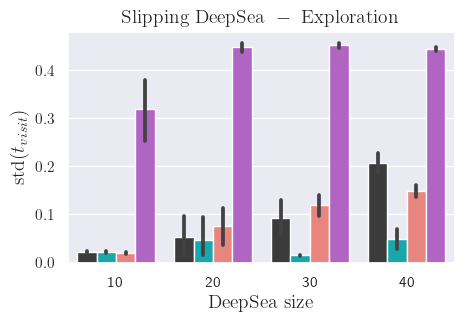

In [134]:
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']

labels_agents = {
    
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative_generative_off_policy': r'\textsc{DBMF-BPI}',
    'boot_dqn_torch': r'\textsc{BSP}',
    
    'ids': r'\textsc{IDS}',
}
colors = {
    'boot_dqn_torch': '#f8766d',
    'boot_dqn_torch_modified': '#3B3B3B',
    'explorative_generative_off_policy': '#00bfc4',
    'ids': 'mediumorchid',
}


#color_dict = {agent: color for agent, color in zip(AGENTS, colors)}
fig, ax = plt.subplots(1,1, figsize=(5,3))
barplot = sns.barplot(x="size", y="spread", hue="method", data=df, palette=colors)
handles, labels = barplot.get_legend_handles_labels()
new_labels = [labels_agents[x] for x in labels]
# plt.legend(handles, new_labels)
plt.xlabel(r'$\mathrm{DeepSea \ size}$', fontsize=AXIS_LABEL)
plt.ylabel(r'$\mathrm{std}(t_{visit})$', fontsize=AXIS_LABEL)
plt.title(r'$\mathrm{Slipping \ DeepSea \ - \ Exploration}$', fontsize=AXIS_LABEL)
ax.get_legend().remove() 
plt.savefig('figures/deep_sea_exploration_small.pdf', bbox_inches='tight')

In [2]:
SIZES = [10,20,30,40]#, 50]
# EPISODES = {10: 500, 15: 1000, 20: 1500, 30: 2500, 40:3500, 50: 4500}
EPISODES = {10: 1000, 20: 2000, 30: 3000, 40: 4000, 50: 50000}
AGENTS = ['boot_dqn_torch_modified', 'explorative_generative_off_policy','boot_dqn_torch', 'ids']


raw_data = {}
data = {}
df = pd.DataFrame({
    'method': [],
    'size': [],
    'hit_time': [],
    'spread': [],
    'confidence': []
})

df_greedy = {x: {y: {'greedy': None, 't': None} for y in AGENTS} for x in SIZES}

for size in SIZES:
    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)
    for agent in AGENTS:
        with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:
            raw_data[size] = pickle.load(f)
            res = np.array(raw_data[size].training_rewards)
            if agent not in data: data[agent] = {}

            idxs = (res > 0).argmax(-1) #* size
            idxs[np.isclose(idxs,0)] = EPISODES[size]# / size
            
            idxs = 1- idxs / EPISODES[size]

            x: Results = raw_data[size]
            # n^2-n is the minimum spread possible, while n^2-2 is the maximum possible spread (as long as the agent has visited all states at least once)
            y = 1 - np.vstack([compute_statistics(x.agent_stats[i], env) for i in range(len(x.agent_stats))]) / (size * EPISODES[size])
            

            hit_mu, hit_se =  CE(idxs)
            spread_mu, spread_se = CE(y[:,5])
    
            df.loc[len(df)] = [agent, size, hit_mu, spread_mu, np.sqrt(hit_se ** 2 + spread_se ** 2)]

            
            res = np.array(raw_data[size].greedy_rewards)[...,1]
            t  = np.array(raw_data[size].greedy_rewards)[0,:,0]
            # for i in range(res.shape[0]):
            #     for j in range(res.shape[1]):
            df_greedy[size][agent]['greedy'] = np.array(res.tolist())
            df_greedy[size][agent]['t'] = t

                


df

/tmp/ipykernel_115805/1881455018.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res = np.array(raw_data[size].greedy_rewards)[...,1]
/tmp/ipykernel_115805/1881455018.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t  = np.array(raw_data[size].greedy_rewards)[0,:,0]
/tmp/ipykernel_115805/1881455018.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' 

,method,size,hit_time,spread,confidence
0,boot_dqn_torch_modified,10,0.918417,0.884879,0.017382
1,explorative_generative_off_policy,10,0.919292,0.898058,0.020956
2,boot_dqn_torch,10,0.875667,0.901854,0.019012
3,ids,10,0.280292,0.198542,0.228155
4,boot_dqn_torch_modified,20,0.679125,0.812524,0.170790
5,explorative_generative_off_policy,20,0.708854,0.834770,0.146342
6,boot_dqn_torch,20,0.501417,0.717335,0.177378
7,ids,20,0.000000,0.024203,0.037660
8,boot_dqn_torch_modified,30,0.415917,0.577657,0.168607
9,explorative_generative_off_policy,30,0.755736,0.884176,0.028613


In [10]:
x = df_greedy[10]['ids']['greedy'].astype(float)


print((x.mean(-1).var(0) + x.var(-1).mean(0))[0])
print(x[:,0,:].flatten().var())

4.193593750000001e-06
4.19359375e-06


boot_dqn_torch_modified
explorative_generative_off_policy
boot_dqn_torch
ids


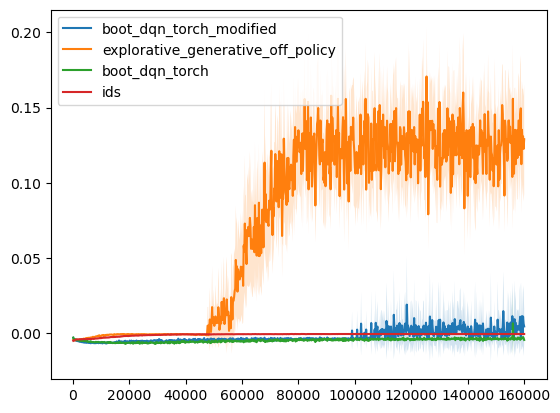

In [26]:
size = 40
c = 0.95
alpha = c + (1-c)/2


for agent in AGENTS:
    print(agent)
    greedy_data = df_greedy[size][agent]['greedy'].astype(float)
    t = df_greedy[size][agent]['t'].astype(int)
    mu = greedy_data.mean(-1).mean(0)
    std =  greedy_data.mean(-1).std(0, ddof=1) #greedy_data.std(-1, ddof=1).mean(0) +
    N = greedy_data.shape[0]
    c = tstudent.ppf(alpha, N)

    se = c * std / np.sqrt(N)

    

    plt.plot(t, mu, label=agent)
    #plt.fill_between(t, mu-se, mu+se)
    plt.fill_between(t, mu-se, mu+se, alpha=0.2)

plt.legend()

In [135]:
SIZES = [10,20,30,40]#,20,30,40]#, 50]
# EPISODES = {10: 500, 15: 1000, 20: 1500, 30: 2500, 40:3500, 50: 4500}
EPISODES = {10: 1000, 20: 2000, 30: 3000, 40: 4000, 50: 5000}
AGENTS = ['boot_dqn_torch_modified', 'explorative_generative_off_policy','boot_dqn_torch', 'ids']


raw_data = {}
data = {size: {agent: None for agent in AGENTS} for size in SIZES}


for size in SIZES:
    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)
    for agent in AGENTS:
        print(f'> Size: {size} - Agent: {agent}')
        with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:
            raw_data[size] = pickle.load(f)
            res = np.array(raw_data[size].training_rewards)
            
            res = res > 0
            res = np.cumsum(res, axis=1)
            data[size][agent] = res

> Size: 10 - Agent: boot_dqn_torch_modified
> Size: 10 - Agent: explorative_generative_off_policy
> Size: 10 - Agent: boot_dqn_torch
> Size: 10 - Agent: ids
> Size: 20 - Agent: boot_dqn_torch_modified
> Size: 20 - Agent: explorative_generative_off_policy
> Size: 20 - Agent: boot_dqn_torch
> Size: 20 - Agent: ids
> Size: 30 - Agent: boot_dqn_torch_modified
> Size: 30 - Agent: explorative_generative_off_policy
> Size: 30 - Agent: boot_dqn_torch
> Size: 30 - Agent: ids
> Size: 40 - Agent: boot_dqn_torch_modified
> Size: 40 - Agent: explorative_generative_off_policy
> Size: 40 - Agent: boot_dqn_torch
> Size: 40 - Agent: ids


array([0.000, 0.000, 0.000, ..., 0.000, 0.000, 0.000])

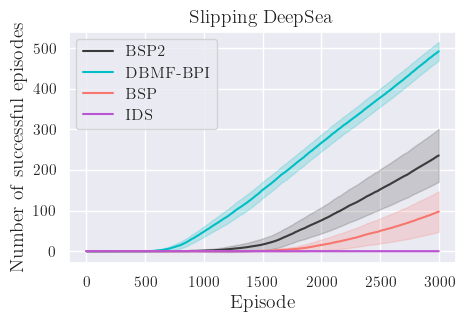

In [136]:
sns.set_style("darkgrid")
c = 0.95
alpha = c + (1-c)/2

fig, ax = plt.subplots(1,1, figsize=(5,3))
colors = ['#f8766d', '#00bfc4', 'mediumorchid','#3B3B3B','#0096FF','#a3a500']
labels = {
    'boot_dqn_torch': r'\textsc{BSP}',
    'boot_dqn_torch_modified': r'\textsc{BSP2}',
    'explorative_generative_off_policy': r'\textsc{DBMF-BPI}',
    'ids': r'\textsc{IDS}',
}
colors = {
    'boot_dqn_torch': '#f8766d',
    'boot_dqn_torch_modified': '#3B3B3B',
    'explorative_generative_off_policy': '#00bfc4',
    'ids': 'mediumorchid',
}


for id_agent, agent in enumerate(AGENTS):
    x = data[30][agent]
    mu = x.mean(0)
    
    N = greedy_data.shape[0]
    c = tstudent.ppf(alpha, N-1)

    se = c * x.std(0, ddof=1) / np.sqrt(N)
    plt.plot(range(x.shape[1]), mu, label=labels[agent], color=colors[agent])
    plt.fill_between(range(x.shape[1]), mu-se, mu+se, alpha=0.2, color=colors[agent])

plt.xlabel(r'$\mathrm{Episode}$', fontsize=AXIS_LABEL)
plt.ylabel(r'$\mathrm{Number \ of \ successful \ episodes}$', fontsize=AXIS_LABEL)
plt.legend()
plt.title(r'$\mathrm{Slipping \ DeepSea}$', fontsize=AXIS_LABEL)


plt.savefig('figures/deepsea_successful_episodes_small.pdf', bbox_inches='tight')

In [43]:
SIZES = [10,20,30,40]#,20,30,40]#, 50]
# EPISODES = {10: 500, 15: 1000, 20: 1500, 30: 2500, 40:3500, 50: 4500}
EPISODES = {10: 1000, 20: 2000, 30: 3000, 40: 4000, 50: 5000}
AGENTS = ['boot_dqn_torch_modified', 'explorative_generative_off_policy','boot_dqn_torch', 'ids']


raw_data = {}
data = {}
df = pd.DataFrame({
    'method': [],
    'size': [],
    'hit_time': [],
    'spread': [],
})

for size in SIZES:
    env = MultiRewardsDeepSea(size, enable_multi_rewards=False, slipping_probability=0.05)
    for agent in AGENTS:
        with lzma.open(f'data/data_{size}_{agent}_maj9.pkl', 'rb') as f:
            raw_data[size] = pickle.load(f)
            res = np.array(raw_data[size].training_rewards)
            if agent not in data: data[agent] = {}

            idxs = (res > 0).argmax(-1) #* size
            idxs[np.isclose(idxs,0)] = EPISODES[size]# / size
            
            idxs = 1- idxs / (EPISODES[size] - size)

            x: Results = raw_data[size]
            y = []
            mask = np.zeros_like(x.agent_stats[0].total_num_visits, dtype=bool)
            mask[np.tril_indices_from(mask)] = True

            # n^2-n is the minimum spread possible, while n^2-2 is the maximum possible spread (as long as the agent has visited all states at least once)
            y = np.array([1-np.std(x.agent_stats[i].last_visit[mask] / np.max(x.agent_stats[i].last_visit[mask]))for i in range(len(x.agent_stats))])# / (size * EPISODES[size])
   
            for i in range(len(idxs)):
                df.loc[len(df)] = [agent, size, idxs[i], y[i]]


['boot_dqn_torch' 'explorative_generative_off_policy' 'ids']


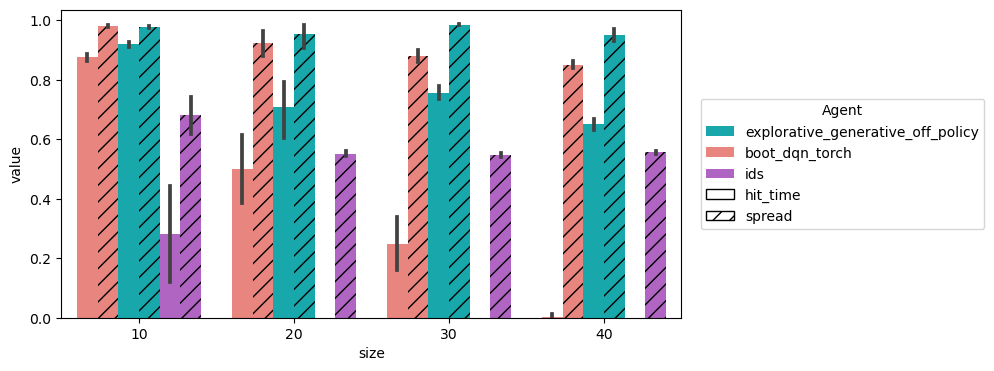

['explorative_generative_off_policy', 'boot_dqn_torch', 'ids', 'hit_time', 'spread']


In [44]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(1,1, figsize=(8,4))
filtered_df = df[df['method'] != 'boot_dqn_torch_modified']
# Assuming df is your DataFrame and it includes 'size', 'method', 'hit_time', and 'spread' columns.

# "Melt" the dataset to have 'size', 'method', 'metric_type', and 'value' columns
df_melted = filtered_df.melt(id_vars=['size', 'method'], value_vars=['hit_time', 'spread'], var_name='metric_type', value_name='value')

# Create a new column that combines 'method' and 'metric_type'
df_melted['method_metric'] = df_melted['method'] + '_' + df_melted['metric_type']

# Sort the dataframe based on 'method' and 'metric_type' so that they appear in the desired order in the plot
df_melted.sort_values(['method', 'metric_type'], inplace=True)

# Create a custom color palette that uses the same color for both metrics of the same method
#palette = sns.color_palette('Set2', n_colors=len(df['method'].unique()))
colors = ['#00bfc4','#f8766d',  'mediumorchid','#3B3B3B','#0096FF','#a3a500',]


custom_palette = {method + '_hit_time': color for method, color in zip(filtered_df['method'].unique(), colors)}
custom_palette.update({method + '_spread': color for method, color in zip(filtered_df['method'].unique(), colors)})

# Create the barplot
barplot = sns.barplot(data=df_melted, x='size', y='value', hue='method_metric', palette=custom_palette)

# Apply the desired patterns to the bars based on the 'metric_type'
hatches = [''] * (len(df_melted['method_metric'].unique()) // 2) + ['//'] * (len(df_melted['method_metric'].unique()) // 2)
print(df_melted['method'].unique())
for i, bar in enumerate(barplot.patches):
    if i < 4 or (i >= 8  and i <= 11) or (i >= 16 and i <= 19):
        bar.set_hatch('')
    else:
        bar.set_hatch('//')
    # bar.set_hatch('' if i != 4 else '//')

# Create custom legend handles and labels
handles, labels = barplot.get_legend_handles_labels()
new_handles = []
new_labels = []
for method in filtered_df['method'].unique():
    new_handles.extend(handles[labels.index(method + '_hit_time'):labels.index(method + '_hit_time')+1])
    new_labels.extend([method])
new_handles.append(mpatches.Patch(facecolor='white', edgecolor='black'))
new_labels.append('hit_time')
new_handles.append(mpatches.Patch(facecolor='white', edgecolor='black', hatch='//'))
new_labels.append('spread')

# plt.subplots_adjust(wspace=0.05)
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels)



# Add the custom legend to the plot
plt.legend(new_handles, new_labels, loc='center right', bbox_to_anchor=(1.5, 0.5), title='Agent')
plt.show()

print(new_labels)

In [51]:
df[df['size'] == 20]

,method,size,hit_time,spread,confidence
4,boot_dqn_torch_modified,20,0.679125,0.812524,0.170790
5,explorative_generative_off_policy,20,0.708854,0.834770,0.146342
6,boot_dqn_torch,20,0.501417,0.717335,0.177378
7,ids,20,0.000000,0.024203,0.037660


/tmp/ipykernel_43402/4106352022.py:10: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  scatter = sns.scatterplot(data=filtered_df, x="hit_time", y="spread", hue="method", palette=palette, ax=ax[axis_id])
/tmp/ipykernel_43402/4106352022.py:10: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  scatter = sns.scatterplot(data=filtered_df, x="hit_time", y="spread", hue="method", palette=palette, ax=ax[axis_id])
/tmp/ipykernel_43402/4106352022.py:10: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  scatter = sns.scatterplot(data=filtered_df, x="hit_time", y="spread", hue="method", palette=palette, ax=ax[axis_id])
/tmp/ipykernel_43402/4106352022.py:10: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  scatter = sns.scatterplot(data=filtered_df, x="hit_time", y="spread", hue="method", palette=palette, ax=a

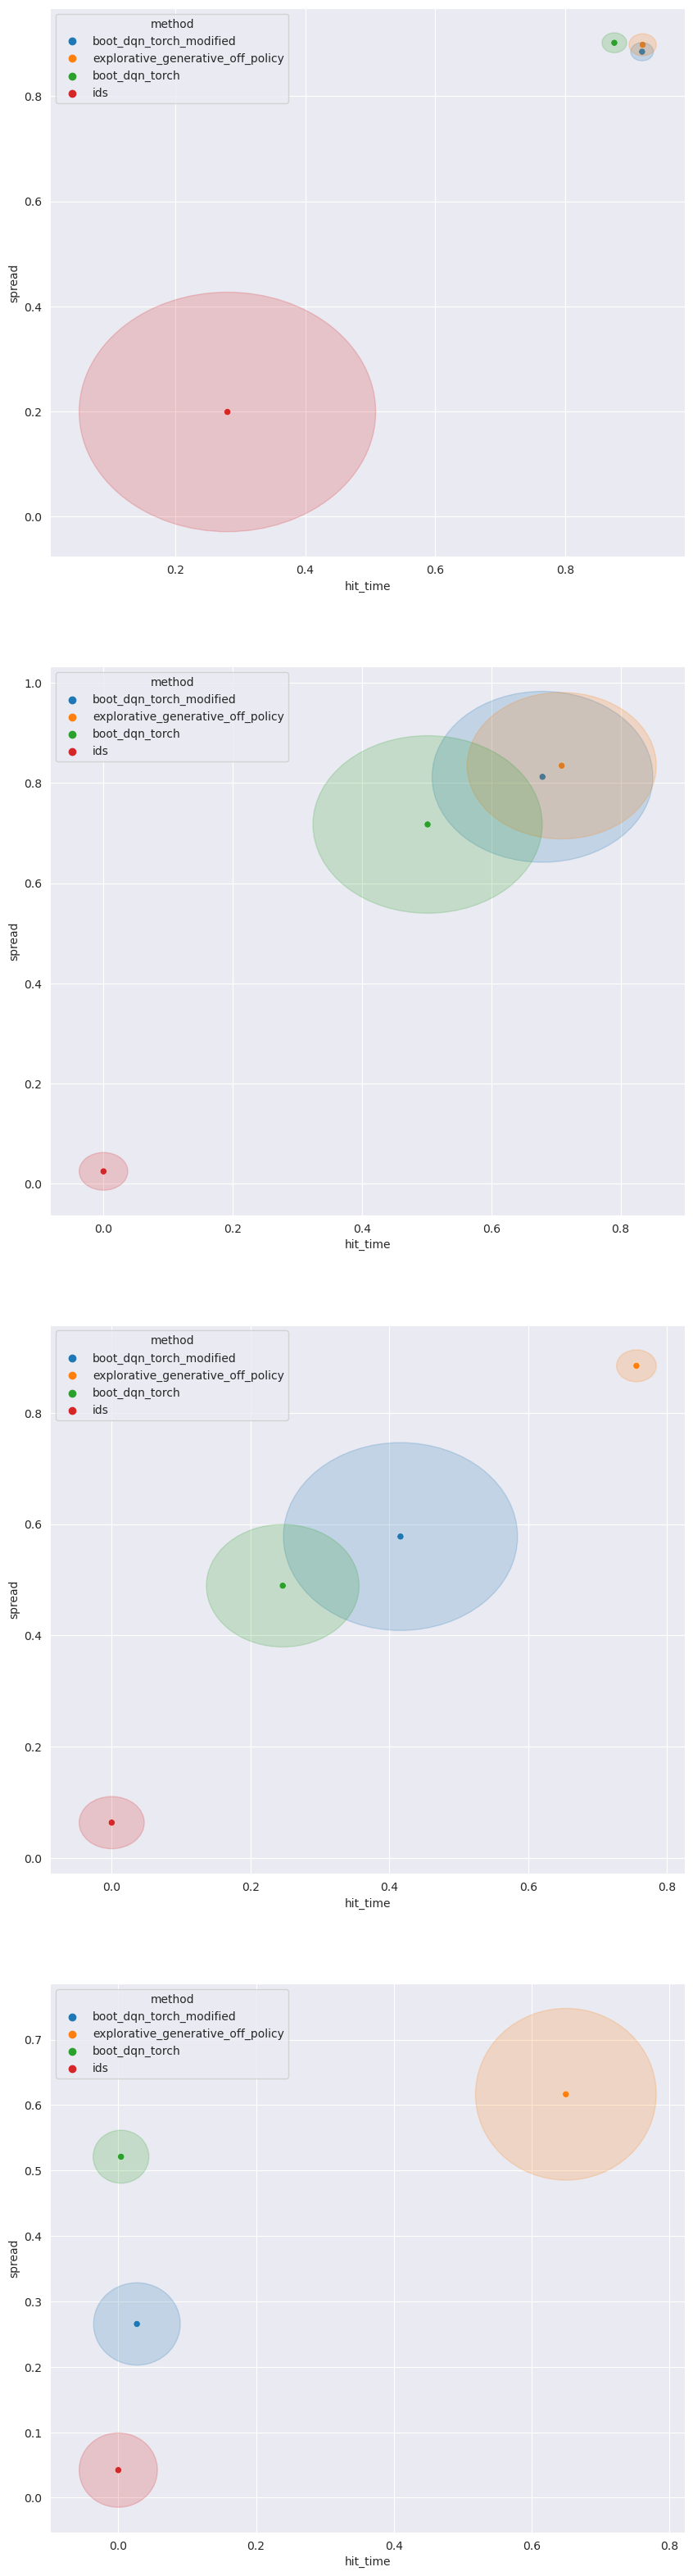

In [57]:

sns.set_style("darkgrid")


fig, ax = plt.subplots(len(SIZES),1, figsize=(10,40))
for axis_id, size in enumerate(SIZES):

    filtered_df = df[df['size'] == size].reset_index(drop=True)

    palette = sns.color_palette()
    scatter = sns.scatterplot(data=filtered_df, x="hit_time", y="spread", hue="method", palette=palette, ax=ax[axis_id])
    for line in range(0, filtered_df.shape[0]):
        scatter.add_patch(plt.Circle((filtered_df["hit_time"][line], filtered_df["spread"][line]), filtered_df['confidence'][line], color=palette[line], fill=True, alpha=0.2))


In [3]:
grouped_df = df.groupby(['method'])
grouped_df.apply(lambda a: a[:])


method  size   
method                                                                          
boot_dqn_torch                    2                      boot_dqn_torch    10  \
                                  6                      boot_dqn_torch    20   
                                  10                     boot_dqn_torch    30   
                                  14                     boot_dqn_torch    40   
boot_dqn_torch_modified           0             boot_dqn_torch_modified    10   
                                  4             boot_dqn_torch_modified    20   
                                  8             boot_dqn_torch_modified    30   
                                  12            boot_dqn_torch_modified    40   
explorative_generative_off_policy 1   explorative_generative_off_policy    10   
                                  5   explorative_generative_off_policy    20   
                                  9   explorative_generative_off_policy    30   
                                  13  explorative_generative_off_policy    40   
ids                               3                                 ids    10   
                                  7                                 ids    20   
                                  11                                ids    30   
                                  15                                ids    40   

                                      episodes  avg_first_hit  ce_first_hit   
method                                                                        
boot_dqn_torch                    2       1000     124.333333     12.220717  \
                                  6       2000     662.888889     78.386757   
                                  10      3000    1891.500000    294.822039   
                                  14      4000    3809.000000    641.095257   
boot_dqn_torch_modified           0       1000      81.583333     12.157567   
                                  4       2000     447.714286    118.099028   
                                  8       3000    1502.700000    257.693797   
                                  12      4000    2702.000000   3239.897506   
explorative_generative_off_policy 1       1000      80.708333      9.201128   
                                  5       2000     453.409091    114.563264   
                                  9       3000     732.791667     73.826586   
                                  13      4000    1400.500000     81.242281   
ids                               3       1000      39.000000     12.681510   
                                  7       2000            NaN           NaN   
                                  11      3000            NaN           NaN   
                                  15      4000            NaN           NaN   

                                      probability_hit  avg_rise_time   
method                                                                 
boot_dqn_torch                    2            100.00     175.000000  \
                                  6             75.00     928.289474   
                                  10            66.67    2382.142857   
                                  14             8.33    4868.750000   
boot_dqn_torch_modified           0            100.00     105.208333   
                                  4             87.50     616.071429   
                                  8             83.33    1883.333333   
                                  12             8.33    3608.333333   
explorative_generative_off_policy 1            100.00     114.583333   
                                  5             91.67     656.818182   
                                  9            100.00    1067.013889   
                                  13           100.00    2012.760417   
ids                               3             29.17      50.000000   
                                  7              0.00            NaN   
                               

In [16]:
NUM_RUNS = len(raw_data[10]['ids'].greedy_rewards)
greedy_data = np.array([list(zip(*raw_data[10]['ids'].greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

mu_groups, std_groups = greedy_data.mean(-1), greedy_data.std(-1, ddof=1)
RSS, ESS = std_groups.mean(0), mu_groups.std(0, ddof=1)
mu, std = mu_groups.mean(0), RSS+ESS
alpha = .95 + (1-.95)/2
c = tstudent.ppf(alpha, NUM_RUNS)
CE = c * std/ np.sqrt(NUM_RUNS)

array([0.002, 0.002, 0.162, 0.300, 0.354, 0.376, 0.328, 0.371, 0.353,
       0.352, 0.346, 0.360, 0.365, 0.341, 0.396, 0.364, 0.360, 0.401,
       0.386, 0.365])

In [39]:
raw_data.keys

<function dict.keys>

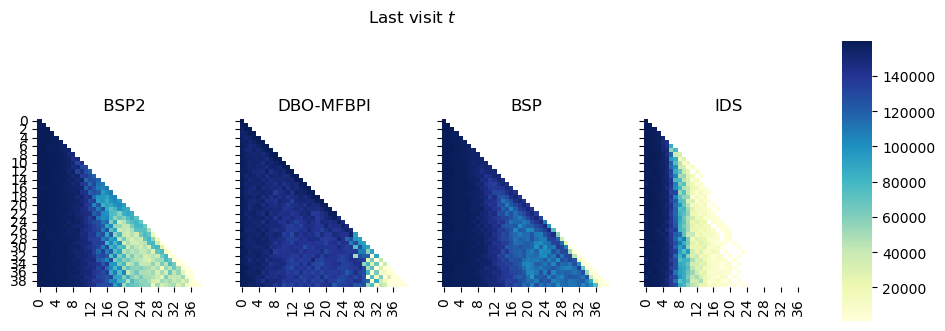

In [42]:
size = 40
fig, ax = plt.subplots(1,4,figsize=(10,4), sharey=True)
cbar_ax = fig.add_axes([.93, .2, .03, .7])
labels = {'explorative_generative_off_policy': 'DBO-MFBPI', 'boot_dqn_torch': 'BSP', 'ids': 'IDS', 'boot_dqn_torch_modified': ' BSP2'}
for agent_id, agent in enumerate(AGENTS):
    last_visit = np.vstack([raw_data[size][agent].agent_stats[x].last_visit[None,...] for x in range(len(raw_data[size][agent].agent_stats))])
    last_visit = last_visit.mean(0)



    mask = np.zeros_like(last_visit, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center="light", as_cmap=True)
    last_visit[np.isclose(0, last_visit)] = np.nan
    with sns.axes_style("white"):
        sns.heatmap(last_visit, square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
    ax[agent_id].set_title(labels[agent])

fig.suptitle('Last visit $t$')
# plt.savefig(f'figures/last_visit_{size}.pdf')
plt.show()

/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: invalid value encountered in multiply
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: divide by zero encountered in log
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21: RuntimeWarning: invalid value encountered in multiply
  sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
/tmp/ipykernel_1422540/1644193227.py:21:

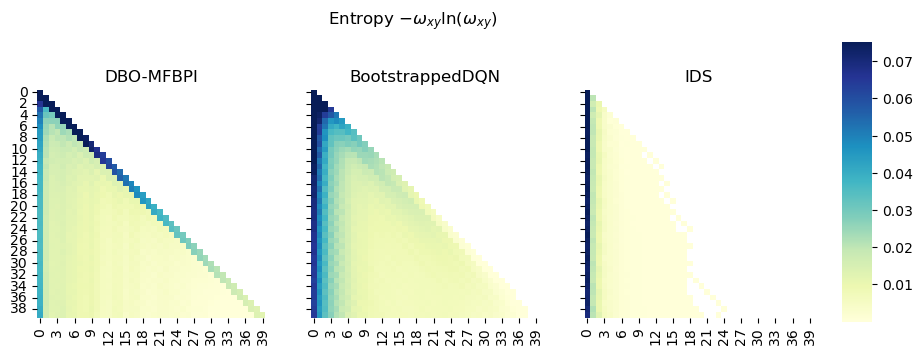

In [9]:
size = 40
fig, ax = plt.subplots(1,3,figsize=(10,4), sharey=True)
cbar_ax = fig.add_axes([.93, .2, .03, .7])
labels = {'explorative_generative_off_policy': 'DBO-MFBPI', 'boot_dqn_torch': 'BootstrappedDQN', 'ids': 'IDS'}

for agent_id, agent in enumerate(raw_data[size].keys()):
    frequency_visits = np.vstack([raw_data[size][agent].agent_stats[x].frequency_visits[None,...] for x in range(len(raw_data[size][agent].agent_stats))])
    frequency_visits = frequency_visits.mean(0)

   

    mask = np.zeros_like(frequency_visits, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    #cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center="light", as_cmap=True)
    with sns.axes_style("white"):
        sns.heatmap(-frequency_visits * np.log(frequency_visits), square=True, cmap="YlGnBu",  ax=ax[agent_id], mask=mask, cbar_ax=cbar_ax, robust=True)
    ax[agent_id].set_title(labels[agent])

fig.suptitle(r'Entropy $-\omega_{xy} \ln(\omega_{xy})$')
plt.savefig(f'figures/frequency_visits_{size}.pdf')
plt.show()

array([[99961.000, nan, nan, ..., nan, nan, nan],
       [99951.333, 99772.667, nan, ..., nan, nan, nan],
       [99955.000, 99533.667, 99421.667, ..., nan, nan, nan],
       ...,
       [99984.667, 99686.000, 99171.333, ..., nan, nan, nan],
       [99983.000, 99777.667, 99353.667, ..., nan, nan, nan],
       [99976.000, 99730.667, 99549.333, ..., nan, nan, nan]])

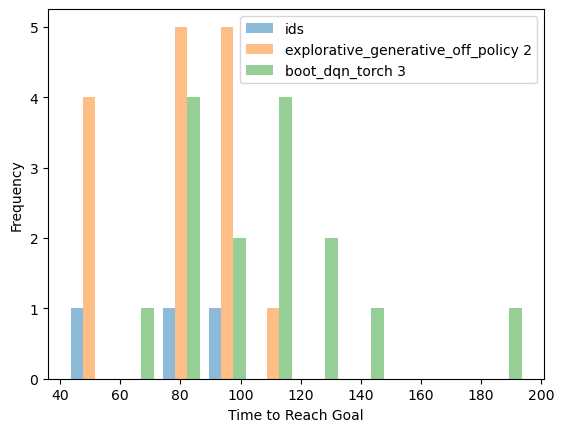

In [72]:
method1_times =data['ids'][10]['first_hit']
method2_times = data['explorative_generative_off_policy'][10]['first_hit']
method3_times = data['boot_dqn_torch'][10]['first_hit']

# Plot histogram
plt.hist([method1_times, method2_times, method3_times], bins=10, alpha=0.5, label=['ids', 'explorative_generative_off_policy 2', 'boot_dqn_torch 3'])
plt.xlabel('Time to Reach Goal')
plt.ylabel('Frequency')
plt.legend(loc='upper right')



plt.show()